In [15]:
import pandas as pd
# Load the matchup dataset 

def prepare_defensive_features(file_path): 
    df_game_1 = pd.read_csv("ATLvsBOS.csv")
    
    # Convert necessary numerical columns 
    numeric_cols = [
        'matchup_field_goals_made', 'matchup_field_goals_attempted', 'matchup_three_pointers_made', 'matchup_three_pointers_attempted', 
        'matchup_free_throws_made', 'matchup_free_throws_attempted', 'matchup_turnovers', 'matchup_blocks', 'help_blocks', 'help_field_goals_made', 
        'help_field_goals_attempted', 'shooting_fouls', 'matchup_minutes_sort', 'player_points'
    ]
    
    for col in numeric_cols: 
        if col in df_game_1.columns:
            df_game_1[col] = pd.to_numeric(df_game_1[col], errors = 'coerce').fillna(0)
        else: 
            print(f"⚠️ Warning: Column {col} missing.")
            df_game_1[col] = pd.to_numeric(df_game_1[col], errors='coerce').fillna(0)
    # Create derived features
    df_game_1["minutes_played"] = df_game_1["matchup_minutes_sort"] / 60 
    df_game_1["matchup_two_pointers_made"] = df_game_1["matchup_field_goals_made"] - df_game_1["matchup_three_pointers_made"]
    df_game_1["matchup_two_pointers_attempted"] = df_game_1["matchup_field_goals_attempted"] - df_game_1["matchup_three_pointers_attempted"]
    
    # Filter qualified defenders (≥ 1300 minutes)
    qualified_minutes = df_game_1.groupby('person_id')['matchup_minutes_sort'].sum()
    qualified_defenders = qualified_minutes[qualified_minutes >= 1300 * 60].index
    df_game_1_qualified = df_game_1.copy()
    
    # Select final features 
    features = df_game_1_qualified[[
        "game_id", "team_name", "first_name", "family_name", "position",
        "matchups_first_name", "matchups_family_name",
        "matchup_field_goals_made", "matchup_field_goals_attempted",
        "matchup_three_pointers_made", "matchup_three_pointers_attempted",
        "matchup_two_pointers_made", "matchup_two_pointers_attempted",
        "matchup_free_throws_made", "matchup_free_throws_attempted",
        "matchup_turnovers", "help_blocks", "help_field_goals_made", "help_field_goals_attempted",
        "shooting_fouls", "player_points", "matchup_minutes_sort", "matchup_minutes"
    ]].copy()

    return features

In [16]:
features_from_game_draft_df = prepare_defensive_features("ATLvsBOS.csv")
features_from_game_draft_df.head(100)

,game_id,team_name,first_name,family_name,position,matchups_first_name,matchups_family_name,matchup_field_goals_made,matchup_field_goals_attempted,matchup_three_pointers_made,...,matchup_free_throws_made,matchup_free_throws_attempted,matchup_turnovers,help_blocks,help_field_goals_made,help_field_goals_attempted,shooting_fouls,player_points,matchup_minutes_sort,matchup_minutes
0,22400001,Celtics,Jaylen,Brown,F,Clint,Capela,0,0,0,...,0,0,0,0,0,0,0,0,34.0,0:34
1,22400001,Celtics,Jaylen,Brown,F,Dyson,Daniels,3,4,0,...,1,2,2,0,0,0,1,7,177.1,2:57
2,22400001,Celtics,Jaylen,Brown,F,Jalen,Johnson,7,13,3,...,3,4,3,0,0,0,2,20,470.7,7:51
3,22400001,Celtics,Jaylen,Brown,F,Garrison,Mathews,1,1,0,...,0,0,0,0,0,0,0,2,41.1,0:41
4,22400001,Celtics,Jaylen,Brown,F,Larry,Nance Jr.,2,3,0,...,0,0,0,0,0,0,0,4,47.2,0:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,22400001,Hawks,Jalen,Johnson,F,Jayson,Tatum,1,2,0,...,0,0,0,0,0,0,0,2,84.7,1:25
96,22400001,Hawks,Jalen,Johnson,F,Jordan,Walsh,0,0,0,...,0,0,1,0,0,0,0,0,7.0,0:07
97,22400001,Hawks,Jalen,Johnson,F,Derrick,White,1,2,1,...,0,0,1,0,0,0,0,3,81.4,1:21
98,22400001,Hawks,Clint,Capela,C,Jaylen,Brown,4,4,0,...,0,2,0,0,0,0,1,8,44.6,0:45


Model Trained
Evaluation Metrics: {'RMSE': 0.183, 'MAE': 0.04, 'R2': 0.99}


<Figure size 1000x600 with 0 Axes>

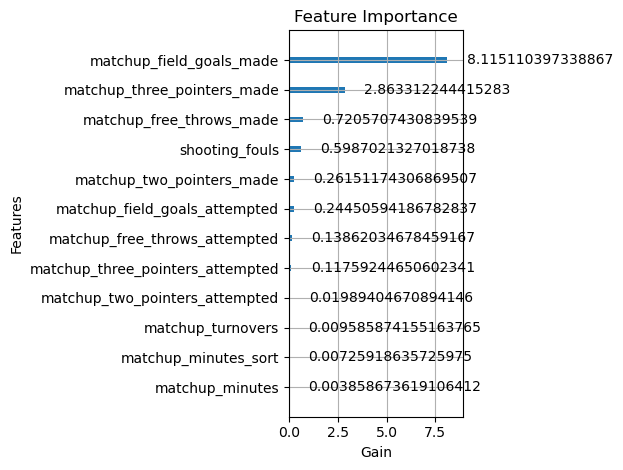

Generating SHAP values...


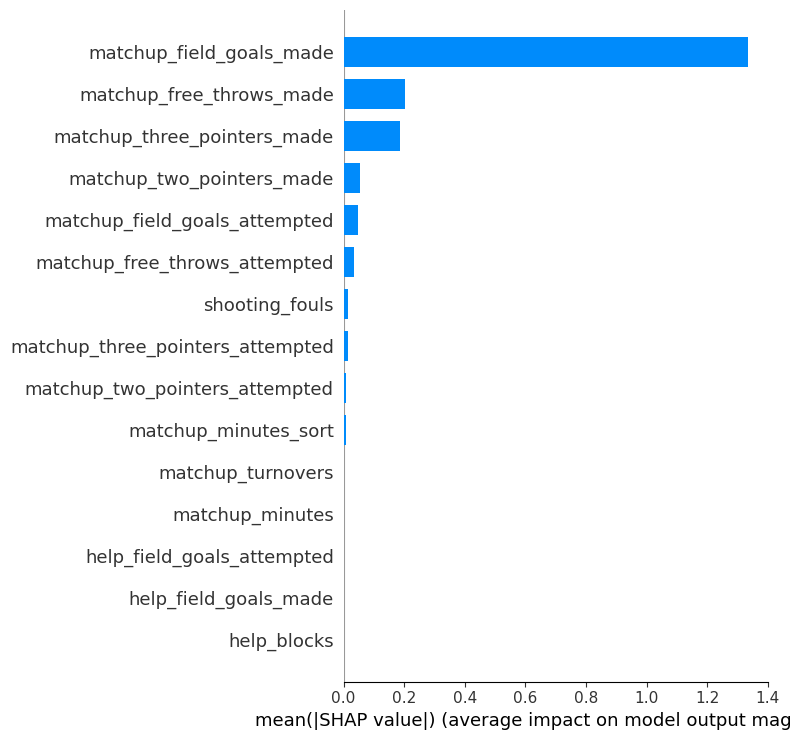

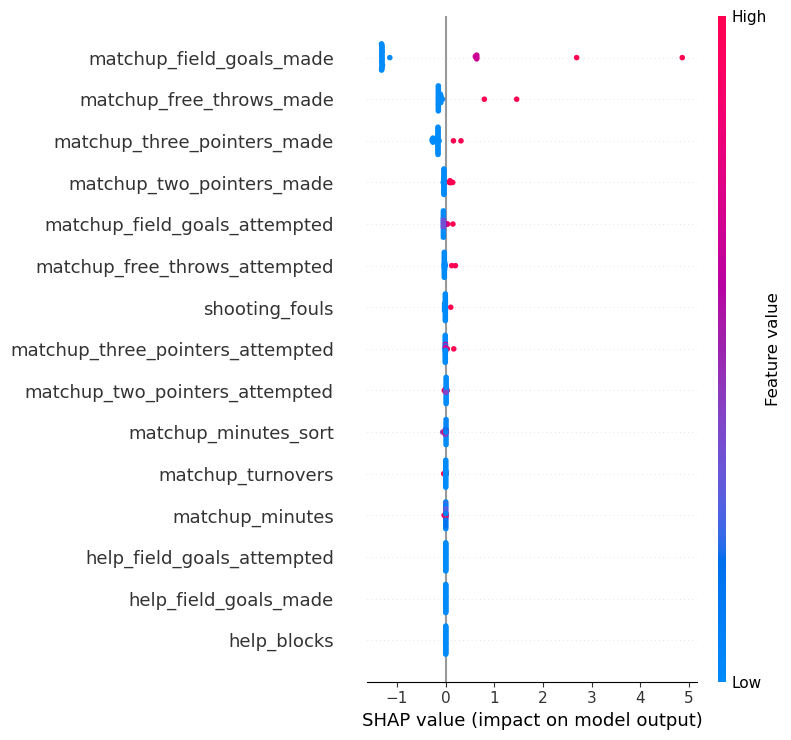


 Top Defenders by Predicted Score Allowed:
   first_name family_name  predicted_score
14    Neemias       Queta        -0.000066
13       Luke      Kornet        -0.000011
9      Jordan       Walsh         0.000275
5    Garrison     Mathews         0.249539
2       David       Roddy         0.666627
16     Payton   Pritchard         0.749798
11     Keaton     Wallace         0.777260
18  Zaccharie    Risacher         0.805001
17        Sam      Hauser         0.857260
10       Jrue     Holiday         0.889310


In [21]:
%matplotlib inline

import pandas as pd 
import numpy as np 
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
import shap
import matplotlib.pyplot as plt 

def train_xgboost_with_interpretability(df, target_col = "player_points", test_size = 0.2, random_state = 42): 
    # This trains an XGBoost model and provides interpretability using SHAP values 
    # Returns: model, defender_scores_df, feature_importances_df, shap_values, X_test, y_test
    
    # Step 1: Drop Missing Target
    df = df.dropna(subset = [target_col])
    
    # Step 2: Identify and exclude non-numeric columns 
    meta_cols = ["game_id", "team_name", "first_name", "family_name", "position", "matchups_first_name", "matchups_family_name"]
    feature_cols = [col for col in df.columns if col not in meta_cols + [target_col]]
    
    X = df[feature_cols]
    y = df[target_col]
    
    # Step 3: Train-test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    
    # Step 4: Train XGBoost Regressor 
    prelim_model = XGBRegressor(
        n_estimators = 300, 
        learning_rate = 0.1, 
        max_depth = 4, 
        subsample = 0.8, 
        colsample_bytree = 0.8, 
        random_state = random_state, 
        objective = 'reg:squarederror'
    )
    prelim_model.fit(X_train, y_train)
    
    # Step 5: Evaluate thhe model 
    y_pred = prelim_model.predict(X_test)
    metrics_prelim = {
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 3), 
        'MAE': round(mean_absolute_error(y_test, y_pred), 3), 
        'R2': round(r2_score(y_test, y_pred), 3)
    }
    
    print("Model Trained")
    print("Evaluation Metrics:", metrics_prelim)
    
    # Step 6: Feature Importance Visualization 
    plt.figure(figsize = (10, 6))
    plot_importance(prelim_model, max_num_features = 15, importance_type = 'gain', title = 'Feature Importance', xlabel = 'Gain')
    plt.tight_layout()
    plt.show()
    
    # Step 7: SHAP Values
    print("Generating SHAP values...")
    explainer = shap.Explainer(prelim_model) 
    shap_values = explainer(X_test)
    
    shap.summary_plot(shap_values, X_test, plot_type = "bar", max_display = 15, show = True)
    shap.summary_plot(shap_values, X_test, max_display = 15, show = True)
    
    # Step 8: Defender Aggression - Average Predicted Score Allowed
    df["predicted_score"] = prelim_model.predict(X[feature_cols])
    defender_scores_df_prelim = df.groupby(['first_name', 'family_name'])["predicted_score"].mean().reset_index()
    defender_scores_df_prelim = defender_scores_df_prelim.sort_values(by = "predicted_score")
    
    print("\n Top Defenders by Predicted Score Allowed:")
    print(defender_scores_df_prelim.head(10))
    
    return prelim_model, defender_scores_df_prelim, shap_values

# Convert 'matchup_minutes' from 'minutes:seconds' format to total minutes as a float
def convert_minutes_to_float(minutes_str):
    try:
        minutes, seconds = map(int, minutes_str.split(':'))
        return minutes + seconds / 60
    except ValueError:
        return 0  # Handle invalid or missing values

features_from_game_draft_df['matchup_minutes'] = features_from_game_draft_df['matchup_minutes'].apply(convert_minutes_to_float)

# Train the model with the updated DataFrame
model, defender_scores_df, shap_values = train_xgboost_with_interpretability(features_from_game_draft_df)

